In [1]:
import numpy as np, matplotlib.pyplot as plt, matplotlib as mpl
import pcmdpy as ppy
from astropy.io import fits
from scipy.misc import face
from scipy.signal import gaussian
plt.style.use('seaborn-poster')
mpl.rcParams['image.origin'] = 'lower'
%matplotlib inline

GPU acceleration not available, sorry
No module named 'pycuda'


In [2]:
mpl.rcParams['image.aspect'] = 'auto'
mpl.rcParams['image.interpolation'] = 'None'


In [3]:
data = fits.open('../data/m49/reduced/m49_chip1_exp1_f850lp_reduced.fits')['sci'].data

In [4]:
masks = fits.open('../data/m49/masks/m49_chip1_thin-annuli.fits')[1].data

In [5]:
masks.max()

99

In [6]:
f = ppy.instrument.ACS_WFC_F814W()

In [7]:
im = np.copy(data)
im[masks != 70] = np.nan

In [8]:
xs, ys = np.where(~np.isnan(im))
x0 = np.min(xs)
x1 = np.max(xs)
y0 = np.min(ys)
y1 = np.max(ys)
im_final = im[x0:x1, y0:y1]

In [9]:
im_final[np.isnan(im_final)] = 0.

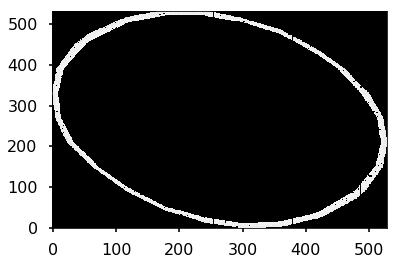

In [10]:
plt.imshow(im_final, cmap='Greys_r')

In [58]:
def gaussian_psf(sig, scale=70):
    kernel = np.outer(gaussian(scale, sig), gaussian(scale, sig))
    return kernel / np.sum(kernel)

In [59]:
def gauss_convolve(im, sig, scale=70):
    f._psf = gaussian_psf(sig, scale=scale)
    return f.psf_convolve(im, multi_psf=False)

In [60]:
def empirical_convolve(im):
    f = ppy.instrument.ACS_WFC_F814W()
    return f.psf_convolve(im, multi_psf=False)

In [70]:
def spatial_correlation(im, a=10):
    nx, ny = im.shape
    im_p = np.fft.fft2(im)
    corr = np.fft.ifft2(im_p * np.conjugate(im_p)).real
    corr /= corr.sum()
    corr = np.roll(np.roll(corr, ny//2, axis=-1), nx//2, axis=-2)
    corr =  corr[(nx//2)-a:(nx//2)+a+1,(ny//2)-a:(ny//2)+a+1]
    Y = np.arange(-a, a+1).repeat(2*a + 1).reshape((2*a+1, 2*a+1))
    X = Y.T
    R = np.sqrt(X**2 + Y**2)
    sort_idx = R.flatten().argsort()
    r = R.flatten()[sort_idx]
    c = corr.flatten()[sort_idx]
    return corr, r, c

In [71]:
f = ppy.instrument.ACS_WFC_F814W()

In [76]:
im_rand = np.random.random((1024, 1024))**1.
im_rand /= im_rand.sum()
im_rand_10 = im_rand**10.
im_rand_10 /= im_rand_10.sum()

Text(0.5,1,'Peaky')

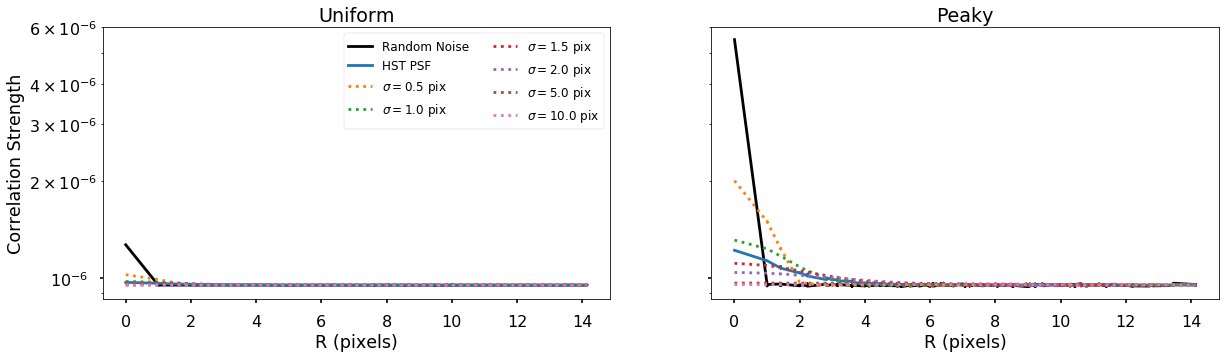

In [77]:
fig, axes = plt.subplots(figsize=(20, 5), ncols=2, sharex=True, sharey=True)
for im, ax in zip([im_rand, im_rand_10], axes):
    _, r_rand, c_rand = spatial_correlation(im)
    ax.plot(r_rand, c_rand, 'k-', label='Random Noise')

    im_conv = empirical_convolve(im)
    _, x, y = spatial_correlation(im_conv)
    ax.plot(x, y, ls='-', marker='', label='HST PSF')
    for sig in [.5, 1., 1.5, 2., 5., 10.]:
        im_conv = gauss_convolve(im, sig)
        _, x, y = spatial_correlation(im_conv)
        ax.plot(x, y, ls=':', marker='', label=r'$\sigma=$' + '{:.1f} pix'.format(sig))
axes[0].legend(loc=0, fontsize=12, ncol=2)
axes[0].set_yscale('log')
axes[0].set_xlabel('R (pixels)')
axes[1].set_xlabel('R (pixels)')
axes[0].set_ylabel('Correlation Strength')
axes[0].set_title('Uniform')
axes[1].set_title('Peaky')
# plt.savefig('figures/spatial_corr_test.pdf')